# <font color='blue'>Capturar dados do Campeonato Brasileiro disponíveis no site da CBF

A ideia deste programa surgiu para exercitar o que estou aprendendo nos meus estudos da linguagem Python. E por gostar muito de futebol, dei uma olhada no site da CBF para verificar se poderia fazer com os dados que estivessem disponíveis no site. Escolhi o campeonato brasileiro para coletar os dados do jogo (localizaçao, data, hora, placar). Abaixo um print dos campos que são o objetivo deste exercício.

<img src="ExemploJogoGols.png">

Exemplo de Link do Jogo: https://www.cbf.com.br/futebol-brasileiro/competicoes/campeonato-brasileiro-serie-a/2019/1

# <font color='black'>Bibliotecas importadas

Pesquisei algumas bibliotecas que me permitiriam executar as ações que eu precisava para capturar, tratar e analisar os dados.

In [1]:
##Imports necessários para capturar os dados da página
import requests
from bs4 import BeautifulSoup
##Import necessário para criação dos dataframes para análise
import pandas as pd
##Import necessário para criar o Profiling
import pandas_profiling as pp
from pandas_profiling import ProfileReport
##Import necessário para criação de gráficos
import matplotlib.pyplot as plt
##Import necessário para trabalhar com data e hora.
import datetime as dtm
from datetime import date as dt
##Import necessário para tratar acentuação
from unicodedata import normalize as nm

# <font color='black'>Funções para tratar campos

Criei este bloco separado, para armazenar as funções que tratarão os campos capturados.
Esta é uma boa prática para deixar o código mais organizado e facilitar a manutenção.

In [2]:
#Esta função captura o número do jogo e a Rodada conforme determinado pela CBF
def numJogoRodada(numJogo):
    ##Tratando a requisição que contém o número do jogo
    num_jogo = int(numJogo.get_text().strip().replace('Jogo: ','').replace('<font color="red">(W.O. Duplo)</font>', ''))

    ##if para calcular a rodada a que o jogo pertence
    '''
        1) A cada rodada ocorrem 10 jogos, sendo assim quando o número do jogo dividido por 10 tiver 0 como resto, a rodada será o quociente.
        Ex: 200 / 10 = 20 - sendo assim a rodada a que pertence o jodo de nº 200 é a 20
        2) Caso o **resto da divisão** do número do jogo for **diferente de 0** então a rodada corresponderá ao quociente (inteiro) + 1
        Ex: 201 / 10 = 20,1 - sendo assim a rodada será 21, pois o resto é 1 e o quociente inteiro é 20.
    '''
    if (num_jogo%10 == 0):
        rodada = int(int(num_jogo)/10)
    else:
        rodada = int((int(num_jogo)//10)+1)

    ##if para calcular o turno ao qual o jogo pertence
    '''
       O Campeonato tem 380 jogos ao todo, sendo:
       - 1º turno: do jogo 1 ao 190
       - 2º turno: do jogo 191 ao 380
    '''
    if int(num_jogo) <= 190:
      turno = 1
    else:
      turno = 2
    ##lista para armazenar o numero do jogo, rodada e turno
    listaResult = [num_jogo, rodada, int(turno)]
    return listaResult

##Remover acentos das strings
def remove_acentos(str):
  str_sem_acentos = nm('NFKD', str).encode('ASCII', 'ignore').decode('ASCII')
  return str_sem_acentos

#Esta função retorna o time mandante e seu estado de origem
def retMandante(captTimes):
    time = captTimes[0].get_text().split("-")[0].strip()
    uf = captTimes[0].get_text().split("-")[1].strip()
    if (uf == 'PR' and (time == 'Athletico Paranaense' or time == 'Atlético Paranaense' or time == 'Atletico' or time == 'Atlético')):
      mandante_origem = 'Athletico Paranaense'
    elif (uf != 'PR' and (time == 'Atlético' or time == 'Atletico')):
      mandante_origem = 'Atlético-'+uf
    elif (time == 'America Fc' or time == 'América Fc' or time == 'America' or time == 'América'):
      mandante_origem = 'América-'+uf
    elif (time == 'Botafogo'):
      mandante_origem = 'Botafogo-'+uf
    elif (time == 'C.r.b.' or time == 'Crb'):
      mandante_origem = 'CRB-'+uf
    elif (time == 'A.b.c.' or time == 'Abc'):
      mandante_origem = 'ABC-'+uf
    elif (time == 'A.s.a.'):
      mandante_origem = 'ASA-'+uf
    elif (time == 'Csa'):
      mandante_origem = 'CSA-'+uf
    else:
      mandante_origem = time
    mandante = remove_acentos(mandante_origem)
    listaMandante = [mandante, uf]
    return listaMandante

#Esta função retorna o time visitante e seu estado de origem
def retVisitante(captTimes):
    time = captTimes[1].get_text().split("-")[0].strip()
    uf = captTimes[1].get_text().split("-")[1].strip()
    if (uf == 'PR' and (time == 'Athletico Paranaense' or time == 'Atlético Paranaense' or time == 'Atletico' or time == 'Atlético')):
      visitante_origem = 'Athletico Paranaense'
    elif (uf != 'PR' and (time == 'Atlético' or time == 'Atletico')):
      visitante_origem = 'Atlético-'+uf
    elif (time == 'America Fc' or time == 'América Fc' or time == 'America' or time == 'América'):
      visitante_origem = 'América-'+uf
    elif (time == 'Botafogo'):
      visitante_origem = 'Botafogo-'+uf
    elif (time == 'C.r.b.' or time == 'Crb'):
      visitante_origem = 'CRB-'+uf
    elif (time == 'A.b.c.' or time == 'Abc'):
      visitante_origem = 'ABC-'+uf
    elif (time == 'A.s.a.'):
      visitante_origem = 'ASA-'+uf
    elif (time == 'Csa'):
      visitante_origem = 'CSA-'+uf
    else:
      visitante_origem = time
    visitante = remove_acentos(visitante_origem)
    listaVisitante = [visitante, uf]
    return listaVisitante

##Esta função retorna uma lista com o Jogador que fez o gol, o Minuto e Tempo do Time Mandante
def lstGolMand(ano, serie, numJogo, time, golJog, dt_ini_cst, dt_fim_cst):
    deQuem = 'Mandante'
    lstFinalGols = []
    if len(golJog) == 0:
        return lstFinalGols
    else:
        lstGolJogMand = golJog[0].get_text().strip()  ##Captura lista dos gols feitos pelo Visitante
        lstItemsGolJogMand = lstGolJogMand.replace('\n','').strip().replace('ºT)', '\n').strip().splitlines()
        for i in lstItemsGolJogMand:
            lstGol = i.split('\' (')
            for n in lstGol:
                lstJogador = lstGol[0].rsplit(" ", 1)[0].strip()  ##Extrai o jogador que fez o Gol
                lstMinuto = 0
                captMinuto = lstGol[0].rsplit(" ", 1)[1]    ##Extrai o Minuto em que o Gol foi feito
                if len(captMinuto) <= 2:
                    lstMinuto = int(captMinuto)
                else:
                    tmpNormal = captMinuto.split('+')[0]
                    tmpAcrescimo = captMinuto.split('+')[1]
                    lstMinuto = int(tmpNormal)+int(tmpAcrescimo)
                lstTempo = lstGol[1]
            lstGols = [ano, serie, numJogo, time, lstJogador, lstMinuto, lstTempo, deQuem, dt_ini_cst, dt_fim_cst]
            lstFinalGols.append(lstGols)
        return lstFinalGols

##Esta função retorna uma lista com o Jogador que fez o gol, o Minuto e Tempo do Time Visitante
def lstGolVisi(ano, serie, numJogo, time, golJog, dt_ini_cst, dt_fim_cst):
    deQuem = 'Visitante'
    lstFinalGols = []
    if len(golJog) == 0:
        return lstFinalGols
    else:
        lstGolJogVisi = golJog[1].get_text().strip()  ##Captura lista dos gols feitos pelo Visitante
        lstItemsGolJogVisi = lstGolJogVisi.replace('\n','').strip().replace('ºT)', '\n').strip().splitlines()
        for i in lstItemsGolJogVisi:
            lstGol = i.split('\' (')
            for n in lstGol:
                lstJogador = lstGol[0].rsplit(" ", 1)[0].strip()  ##Extrai o jogador que fez o Gol
                lstMinuto = 0
                captMinuto = lstGol[0].rsplit(" ", 1)[1]    ##Extrai o Minuto em que o Gol foi feito
                if len(captMinuto) <= 2:
                    lstMinuto = int(captMinuto)
                else:
                    tmpNormal = captMinuto.split('+')[0]
                    tmpAcrescimo = captMinuto.split('+')[1]
                    lstMinuto = int(tmpNormal)+int(tmpAcrescimo)
                lstTempo = lstGol[1]
            lstGols = [ano, serie, numJogo, time, lstJogador, lstMinuto, lstTempo, deQuem, dt_ini_cst, dt_fim_cst]
            lstFinalGols.append(lstGols)
        return lstFinalGols

# <font color='black'>Capturando dados

In [3]:
##Lista para armazenar as séries que serão pesquisadas
lstSerie = ['a','b']
##Variável para armazenar o início do link que será utilizado para extrair os dados.
linkRaiz = 'https://www.cbf.com.br/futebol-brasileiro/competicoes/campeonato-brasileiro-serie-'

##Lista para armazenar quem fez o gol, quando fez, em que tempo fez e qual o
listaFinalGols = []

for i in lstSerie:                ##Este loop foi criado, para varrer a lista a ser pesquisada (permite buscar a Série B).
    serie = i                     ##Esta variável será utilizada para compor o link do jogo.
    for j in range(2012, 2020):   ##Range com as temporadas a serem pesquisadas. A temporada inicial disponível é 2012
        ano = j                   ##Esta variável será utilizada para compor o link do jogo.
        for nj in range (1, 381): ##range de jogos a ser pesquisada. Não pode ser maior do que 380.
            linkJogo = linkRaiz+serie+'/'+str(ano)+'/'+str(nj)                 ##Link completo do jogo a ser capturado
            requisicao = requests.get(linkJogo)
            
            ##Data de Início da Consulta
            dtm_ini_cst = dtm.datetime.now()                    ##Coleta a data e hora em que a consulta começou
            dt_ini_cst = dtm_ini_cst.strftime("%Y-%m-%d %H:%M:%S.%f") ##Formatando a data e hora em que a consulta começou
            
            soup = BeautifulSoup(requisicao.content, 'html.parser')

            num_jogo = numJogoRodada(soup.find(class_='color-white block text-1'))[0]   ##Numero do Jogo
            num_rodada = numJogoRodada(soup.find(class_='color-white block text-1'))[1] ##Numero da Rodada
            num_turno = numJogoRodada(soup.find(class_='color-white block text-1'))[2]  ##Numero do Turno

            captTimes = soup.find_all(class_='time-nome color-white')          ##Variável com os times
            mandante = retMandante(captTimes)[0]                               ##Mandante do jogo
            visitante = retVisitante(captTimes)[0]                             ##Visitante do jogo     
            ufMandante = retMandante(captTimes)[1]                             ##UF Mandante do jogo
            ufVisitante = retVisitante(captTimes)[1]                           ##UF Visitante do jogo

            ##Este bloco visa capturar as informações sobre os gols: quem fez, quando fez, tempo que fez etc.
            golJog = soup.find_all(class_='hidden-sm hidden-md hidden-lg m-t-20') ##Lista de Jogadores e tempo dos Gols

            ##Data de Finalização da Consulta
            dtm_fim_cst = dtm.datetime.now()                    ##Coleta a data e hora em que a consulta foi executada
            dt_fim_cst = dtm_fim_cst.strftime("%Y-%m-%d %H:%M:%S.%f") ##Formatando a data e hora da consulta
            
            ##Captura informações sobre os Gosl do Mandante
            lstGolsM = lstGolMand(str(ano), serie.upper(), num_jogo, mandante, golJog, dt_ini_cst, dt_fim_cst)
            ##Captura informações sobre os Gosl do Visitante
            lstGolsV = lstGolVisi(str(ano), serie.upper(), num_jogo, visitante, golJog, dt_ini_cst, dt_fim_cst)

            for i in lstGolsM:
                listaFinalGols.append(i)
            for i in lstGolsV:
                listaFinalGols.append(i)


<font color='red'>OBS: <font color='black'>No site tem dados disponíveis desde 2012, entretanto ao colocar para pesquisar de 2012 a 2019 o programa apresentou diversas vezes erro. Não consegui identificar o porquê. Inicialmente, achei que era algum erro no código, porém ao rodar ano a ano o programa funciona corretamente, então acho que pode ser algum erro de rede ou memória. Se alguém souber ou conseguir descobrir o que é e puder me ensinar, ficarei muito feliz. Filtrando de 2014 a 2019 não deu erro e funcionou melhor.

# <font color='black'>Construindo Dataframe com os dados capturados

Os dados foram armazenados em um Dataframe: 
 - por ser semelhante a uma tabela de banco de dados (estrutura de armazenamento a qual estou mais acostumado a trabalhar)
 - porque nas minhas pesquisas, o Pandas foi a biblioteca mais recomendada para análise de dados (!), aí quis experimentar (rs!)

## <font color='green'>Dataframe com dados dos Gols

In [4]:
dfg = pd.DataFrame(##Passando a lista onde foram armazenados os jogos capturados.
                    listaFinalGols
                      ##Nomeando as colunas do Dataframe
                      , columns = ['Temporada', 'Série', 'Número do Jogo'
                                    , 'Time', 'Jogador', 'Minuto', 'Tempo', 'De Quem'
                                    , 'Data de Início da Consulta', 'Data de Fim da Consulta'])

## <font color='green'>Exibindo o Dataframe com dados dos Gols

In [5]:
dfg.sort_values(by=['Temporada', 'Série', 'Número do Jogo', 'Tempo', 'Minuto'])

,Temporada,Série,Número do Jogo,Time,Jogador,Minuto,Tempo,De Quem,Data de Início da Consulta,Data de Fim da Consulta
0,2012,A,104,Internacional,Elton,20,1,Mandante,2020-10-19 00:23:01.903704,2020-10-19 00:23:01.934513
4,2012,A,104,Atletico-GO,Renie,27,1,Visitante,2020-10-19 00:23:01.903704,2020-10-19 00:23:01.934513
1,2012,A,104,Internacional,Dagoberto,1,2,Mandante,2020-10-19 00:23:01.903704,2020-10-19 00:23:01.934513
2,2012,A,104,Internacional,Jakson Avelino,13,2,Mandante,2020-10-19 00:23:01.903704,2020-10-19 00:23:01.934513
3,2012,A,104,Internacional,Fred,31,2,Mandante,2020-10-19 00:23:01.903704,2020-10-19 00:23:01.934513
...,...,...,...,...,...,...,...,...,...,...
12421,2019,B,379,Coritiba,Wanderley,16,2,Visitante,2020-10-19 01:47:58.182253,2020-10-19 01:47:58.306180
12422,2019,B,379,Coritiba,Wanderley,31,2,Visitante,2020-10-19 01:47:58.182253,2020-10-19 01:47:58.306180
12424,2019,B,380,Vila Nova,Bruno Mezenga,13,1,Visitante,2020-10-19 01:47:58.884735,2020-10-19 01:47:58.931083
12423,2019,B,380,Cuiaba,Moises,26,2,Mandante,2020-10-19 01:47:58.884735,2020-10-19 01:47:58.931083


### <font color='green'>Salvado o Dataframe em Excel

In [6]:
dfg.to_excel("CampeonatoBrasileiro_Gols_CBF_20121017_SerieAB.xlsx", index = False)

# <font color='black'>Profiling

O profiling é a primeira etapa que deve ser executada ao receber um dataset para análise, pois permite efetuar diversas validações como:

 - Estruturais:
     * Identificar tipo de dados
     * Formato do Dados (Ex: Campos de data podem ser econtrados como 'DD/MM/AAAA', 'AAAA-MM-DD', 'MM/DD/AAAA' etc)
     * Precisão dos campos (Ex: o número de casas decimais em campos com valores monetários ou número científicos, a depender do contexto, em que estão inseridos fazem total diferença)
 - Completude (o quanto aquela variável está preenchida)
 - Consistência:
     * Valores máximos, mínimos, médias etc
     * Identificar Outliers
 
Além de apontar:

  - Campos possíveis de se tornarem chaves para o dataset
  - Campos possíveis de se tornarem Domínio
 
Essas informações extraídas do Profiling podem direcionar diversas ações e resultados

 - Elaboração de regras para limpeza e tratamento dos dados
 - Elaboração de regras para deduplicação de registros
 - Promover a conscientização da importância da Qualidade de Dados
 - Redução do tempo gasto na preparação dos dados
 - Indicar que tipo de operação pode ser efetuada com um campo

# <font color='black'>Construindo o Profiling

In [7]:
profileGol = ProfileReport(##Passando o Dataframe de Parâmetro
                        dfg
                        ##Colocando o título do profiling
                        , title="Profiling dos dados do Campeonato Brasileiro")

# <font color='black'>Exibindo o Profiling

In [8]:
profileGol

<font color='red'>OBS: <font color='black'>Ao analisar o resultado do Profiling nos testes enquanto desenvolvia o código, percebi que precisava tratar o nome do time. Em diversas edições do campeonato, por exemplo, temos mais de um Atlético participando (o Mineiro; o Goianiense; o Paranaense, que trocou para 'Athletico Paranaense' recentemente e etc). Este tratamento foi feito nas funções retMandante e retVisitante.

# <font color='black'>Calculando a quantidade de Gols por minuto e tempo

O Pandas permite fazer uma série de operações para análise dos dados. 
Pesquisei alguns comandos simples para exemplificar uma das possibilidades, onde calculei a quantidade de gols por Minuto e Tempo.

In [9]:
##Criando um 'sub'-dataframe para armazenar o grupo que será analisado
##Fiz um agrupamento pelas dimensões Minuto e Tempo e contei a quantidade de registros
qtdGols = dfg.groupby(['Minuto', 'Tempo']).count()[['Série']]

# <font color='black'>Exibindo o dataframe criado para armazenar o grupo a ser analisado

In [10]:
qtdGols

Série
Minuto Tempo       
1      1         91
       2        119
2      1        102
       2        121
3      1         84
...             ...
52     2          4
53     1          1
       2          1
54     2          3
55     2          1

[109 rows x 1 columns]

# <font color='black'>Criando dataframes que sumarizem os dados por minuto de cada tempo de jogo.

In [11]:
##Filtrei os dados relativos ao primeiro tempo e sumarizei-os por minuto de jogo
golPriTmp = qtdGols.query('Tempo == "1"').groupby(['Minuto']).sum()[['Série']]
##Filtrei os dados relativos ao segundo tempo e sumarizei-os por minuto de jogo
golSegTmp = qtdGols.query('Tempo == "2"').groupby(['Minuto']).sum()[['Série']]

# <font color='black'>Quantidade de Gols por Minuto dos Jogos em gráfico

O matplotlib permite criar diversos tipos de gráficos. Pesquisei alguns comandos simples para exibir a quantidade de gols feitas em cada minuto dos jogos.

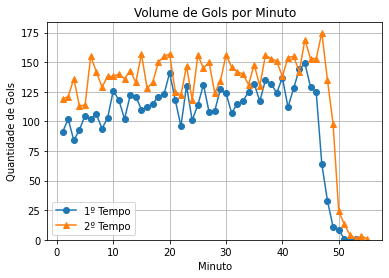

In [12]:
plt.plot(golPriTmp, marker="o")                ##Plotando a qtd de gols efetuados no 1º tempo dos jogos
plt.plot(golSegTmp, marker="^")                ##Plotando a qtd de gols efetuados no 2º tempo dos jogos
plt.rcParams['figure.figsize'] = (20,7)        ##Setando o tamanho do gráfico que será exibido
plt.legend(['1º Tempo', '2º Tempo'])           ##Adicionando a legenda para as categorias criadas.
plt.ylim(0)                                    ##Setando o eixo mínimo do gráfico para melhorar a visualização
plt.grid()                                     ##Incluindo as linhas de grade
plt.title('Volume de Gols por Minuto')         ##Título do Gráfico
plt.xlabel('Minuto')                           ##Título do Eixo x
plt.ylabel('Quantidade de Gols')               ##Título do Eixo y
plt.show()                                     ##Exibindo o gráfico

Neste gráfico, plotei apenas a volumetria geral por minutos independente da temporada, mas outras análises interessantes a serem feitas é a quebra de temporada e tempo do jogo

# <font color='black'>Por hoje é só, Pessoal!